In [289]:
import csv
import requests
import datetime
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns
% matplotlib inline

#!curl -O http://web.mta.info/developers/data/nyct/turnstile/turnstile_160528.txt

In [290]:
mta_raw = defaultdict(list)
mta_dt = defaultdict(list)
mta_cum_entries = defaultdict(list)
mta_cum_exits = defaultdict(list)
mta_entries = defaultdict(list)
mta_exits = defaultdict(list)
mta_combined = defaultdict(list)
mta_master = defaultdict(list)
mta_traffic = defaultdict(list)

with open('Mar_Apr_May.txt') as f:
    reader = csv.reader(f)
    next(reader, None)
    for row in reader:
        key = tuple(row[:5])
        raw = row[6:]
        dt = datetime.datetime.strptime(row[6] + " " + row[7], '%m/%d/%Y %H:%M:%S')    
        cum_entries = row[9]
        cum_exits = row[10]
        mta_raw[key].append(raw)
        mta_dt[key].append(dt)
        mta_cum_entries[key].append(cum_entries)
        mta_cum_exits[key].append(cum_exits)

for k, v in mta_cum_entries.items():
    for x in range(len(v)-1):
        mta_entries[k].append(int(v[x+1])-int(v[x]))
        
for k, v in mta_cum_exits.items():
    for x in range(len(v)-1):
        mta_exits[k].append(int(v[x+1])-int(v[x]))

In [291]:
for k, v in mta_entries.items():
    for x in range(len(v)):
        if 0<= v[x] + mta_exits[k][x] <= 10000:
            mta_traffic[k].append(v[x] + mta_exits[k][x])
    
for k, v in mta_dt.items():
    pairs = zip(v, v, v, v, mta_traffic[k])
    mta_combined[k].append(pairs)

In [292]:
for k, v in mta_combined.items():
    l = ()
    for x in range(len(v[0])):
        month = datetime.date(1900, (datetime.datetime.date(v[0][x][0]).month), 1).strftime('%m')
        day = datetime.datetime.date(v[0][x][1])
        wday = datetime.datetime.isoweekday(v[0][x][2])
        interval = datetime.datetime.time(v[0][x][3])
        count = v[0][x][4]
        l = (month, day, wday, interval, count)
        mta_master[k].append(l)

In [293]:
mylist = []
for k,v in mta_master.items():
    for x in v:
        mylist.append([k[0],k[1],k[2],k[3],k[4],x[0],x[1],x[2],x[3],x[4]])

In [294]:
df = pd.DataFrame(mylist, columns = ('C/A','Unit','SCP','Station','LineName','Month','Day','Weekday','Interval','Traffic'))

In [295]:
def calc_timeblock (t):  
   r =  int ( round ((t.minute + (t.hour*60.0)) / 240.0) % 6 )
   return r

In [296]:
bin_4 = df["Interval"].apply(calc_timeblock)
df['TimeBlock'] = bin_4

In [297]:
df.head()

,C/A,Unit,SCP,Station,LineName,Month,Day,Weekday,Interval,Traffic,TimeBlock
0,R238A,R046,02-03-02,GRD CNTRL-42 ST,4567S,02,2016-02-27,6,03:00:00,0,1
1,R238A,R046,02-03-02,GRD CNTRL-42 ST,4567S,02,2016-02-27,6,07:00:00,0,2
2,R238A,R046,02-03-02,GRD CNTRL-42 ST,4567S,02,2016-02-27,6,11:00:00,0,3
3,R238A,R046,02-03-02,GRD CNTRL-42 ST,4567S,02,2016-02-27,6,15:00:00,0,4
4,R238A,R046,02-03-02,GRD CNTRL-42 ST,4567S,02,2016-02-27,6,19:00:00,0,5


In [298]:
pd.pivot_table(df, index = ['Station','LineName','Month','Weekday','TimeBlock'], values = ['Traffic'], aggfunc=np.sum)

Traffic
Station   LineName Month Weekday TimeBlock         
1 AV      L        02    1       0             1614
                                 1             1778
                                 2            12125
                                 3             6818
                                 4            12148
                                 5             7630
                         6       0             6076
                                 1             3018
                                 2             5366
                                 3             7886
                                 4            10333
                                 5            10430
                         7       0             1743
                                 1             1096
                                 2             2973
                                 3             7083
                                 4             8168
                                 5             5415
                   03    1       0             3897
                                 1            15336
                                 2            43877
                                 3            32022
                                 4            48055
                                 5            25805
                         2       0             6439
                                 1            18972
                                 2            56629
                                 3            38274
                                 4            62192
                                 5            37056
...                                             ...
ZEREGA AV 6        05    5       5             1460
                         6       0              353
                                 1              878
                                 2             1005
                                 3             1191
                                 4             1005
                                 5              646
                         7       0              207
                                 1              527
                                 2              939
                                 3              956
                                 4              903
                                 5              970
                   06    3       0              133
                                 1             1651
                                 2              890
                                 3             1164
                                 4             1242
                                 5              397
                         4       0              152
                                 1             1685
                                 2              789
                                 3             1165
                                 4             1193
                                 5              369
                         5       0              139
                                 1             1592
                                 2              777
                                 3             1156
                                 4             1115

[75885 rows x 1 columns]

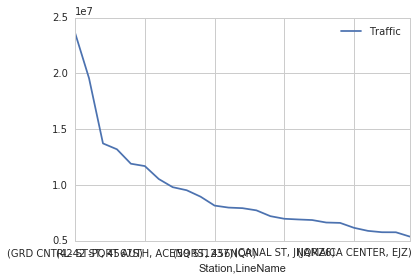

In [299]:
pt_total = pd.pivot_table(df, index = ['Station', 'LineName'], values = ['Traffic'], aggfunc=np.sum)
pt_total.sort_values(by=('Traffic'), ascending=False, inplace=True)
pt_total[0:25].plot()

In [300]:
pt_month = pd.pivot_table(df, index = ['Station', 'LineName'], columns = ['Month'], values = ['Traffic'], aggfunc=np.sum, margins=True, fill_value=0)
pt_month.sort_values(by=('Traffic', 'All'), ascending=False, inplace=True)
pt_month[0:10]

Traffic                            \
Month                                02           03           04   
Station         LineName                                            
All                          20580766.0  284530273.0  268613631.0   
GRD CNTRL-42 ST 4567S          482166.0    7778408.0    7218010.0   
34 ST-HERALD SQ BDFMNQR        447556.0    6348606.0    5959748.0   
TIMES SQ-42 ST  1237ACENQRS    328408.0    4470365.0    4170163.0   
34 ST-PENN STA  ACE            277181.0    4283178.0    4052036.0   
14 ST-UNION SQ  LNQR456        289924.0    3820211.0    3665233.0   
42 ST-PORT AUTH ACENQRS1237    275091.0    3784774.0    3568634.0   
86 ST           456            253800.0    3310316.0    3241365.0   
47-50 STS ROCK  BDFM           195927.0    3190185.0    2977066.0   
FLUSHING-MAIN   7              242378.0    3004676.0    2909176.0   

                                                                   
Month                                 05          06          All  
Station         LineName                                           
All                          276133541.0  30757618.0  880615829.0  
GRD CNTRL-42 ST 4567S          7267677.0    883154.0   23629415.0  
34 ST-HERALD SQ BDFMNQR        6130288.0    684709.0   19570907.0  
TIMES SQ-42 ST  1237ACENQRS    4296716.0    460800.0   13726452.0  
34 ST-PENN STA  ACE            4114915.0    472545.0   13199855.0  
14 ST-UNION SQ  LNQR456        3725386.0    406022.0   11906776.0  
42 ST-PORT AUTH ACENQRS1237    3676473.0    390810.0   11695782.0  
86 ST           456            3361223.0    368743.0   10535447.0  
47-50 STS ROCK  BDFM           3070661.0    370317.0    9804156.0  
FLUSHING-MAIN   7              3055128.0    319472.0    9530830.0

In [301]:
pt_weekday = pd.pivot_table(df, index = ['Station', 'LineName'], columns = ['Weekday'], values = ['Traffic'], aggfunc=np.sum, margins=True, fill_value=0)
pt_weekday.sort_values(by=('Traffic', 'All'), ascending=False, inplace=True)
pt_weekday[0:10]

Traffic                            \
Weekday                                1            2            3   
Station         LineName                                             
All                          136774414.0  147755486.0  150304941.0   
GRD CNTRL-42 ST 4567S          3921619.0    4302755.0    4294903.0   
34 ST-HERALD SQ BDFMNQR        3001074.0    3246832.0    3332899.0   
TIMES SQ-42 ST  1237ACENQRS    1945806.0    2162051.0    2260905.0   
34 ST-PENN STA  ACE            2099276.0    2235281.0    2259063.0   
14 ST-UNION SQ  LNQR456        1741765.0    1898180.0    1982555.0   
42 ST-PORT AUTH ACENQRS1237    1780669.0    1868411.0    1904289.0   
86 ST           456            1587773.0    1735299.0    1744574.0   
47-50 STS ROCK  BDFM           1625232.0    1795608.0    1826474.0   
FLUSHING-MAIN   7              1475821.0    1548116.0    1570550.0   

                                                                               \
Weekday                                4            5           6           7   
Station         LineName                                                        
All                          150220025.0  143518975.0  85616406.0  66425582.0   
GRD CNTRL-42 ST 4567S          4324688.0    3982170.0   1598164.0   1205116.0   
34 ST-HERALD SQ BDFMNQR        3334583.0    3301184.0   1919011.0   1435324.0   
TIMES SQ-42 ST  1237ACENQRS    2262558.0    2223453.0   1618147.0   1253532.0   
34 ST-PENN STA  ACE            2283937.0    2230854.0   1155312.0    936132.0   
14 ST-UNION SQ  LNQR456        1961627.0    1940730.0   1378089.0   1003830.0   
42 ST-PORT AUTH ACENQRS1237    1914953.0    1935667.0   1271497.0   1020296.0   
86 ST           456            1746150.0    1724260.0   1137711.0    859680.0   
47-50 STS ROCK  BDFM           1826573.0    1719155.0    572419.0    438695.0   
FLUSHING-MAIN   7              1552470.0    1515897.0   1048533.0    819443.0   

                                          
Weekday                              All  
Station         LineName                  
All                          880615829.0  
GRD CNTRL-42 ST 4567S         23629415.0  
34 ST-HERALD SQ BDFMNQR       19570907.0  
TIMES SQ-42 ST  1237ACENQRS   13726452.0  
34 ST-PENN STA  ACE           13199855.0  
14 ST-UNION SQ  LNQR456       11906776.0  
42 ST-PORT AUTH ACENQRS1237   11695782.0  
86 ST           456           10535447.0  
47-50 STS ROCK  BDFM           9804156.0  
FLUSHING-MAIN   7              9530830.0

In [302]:
pt_day = pd.pivot_table(df, index = ['Station', 'LineName'], columns = ['Day'], values = ['Traffic'], aggfunc=np.sum, margins=True, fill_value=0)
pt_day.sort_values(by=('Traffic', 'All'), ascending=False, inplace=True)
pt_day_10 = pt_day[0:11]
pt_day_rm_row = pt_day_10['Traffic'].iloc[1:]
pt_day_final = pt_day_rm_row.T.iloc[:-1]

In [303]:
#pt_day_final.plot(kind='box', figsize=[16,8])
pt_day_final

Station,GRD CNTRL-42 ST,34 ST-HERALD SQ,TIMES SQ-42 ST,34 ST-PENN STA,14 ST-UNION SQ,42 ST-PORT AUTH,86 ST,47-50 STS ROCK,FLUSHING-MAIN,59 ST COLUMBUS
LineName,4567S,BDFMNQR,1237ACENQRS,ACE,LNQR456,ACENQRS1237,456,BDFM,7,ABCD1
Day,,,,,,,,,,
2016-02-27,109601.0,133807.0,112235.0,69963.0,93314.0,80821.0,79259.0,45183.0,75387.0,57476.0
2016-02-28,80914.0,97620.0,83260.0,53555.0,70951.0,65833.0,58707.0,31336.0,57801.0,47268.0
2016-02-29,291651.0,216129.0,132913.0,153663.0,125659.0,128437.0,115834.0,119408.0,109190.0,99466.0
2016-03-01,302402.0,225397.0,145663.0,161067.0,132305.0,130052.0,121342.0,123787.0,110836.0,104882.0
2016-03-02,307509.0,225835.0,152391.0,156098.0,133896.0,136288.0,119876.0,128229.0,109556.0,105278.0
2016-03-03,315047.0,232763.0,152307.0,163401.0,134656.0,138756.0,120375.0,128539.0,109053.0,106960.0
2016-03-04,301375.0,234262.0,155637.0,162245.0,133364.0,139627.0,123024.0,126168.0,110648.0,95362.0
2016-03-05,114266.0,141708.0,114639.0,74145.0,94522.0,84981.0,80706.0,44926.0,69349.0,58951.0


[<matplotlib.text.Text at 0x1a5651a50>, <matplotlib.text.Text at 0x1f8f86fd0>]

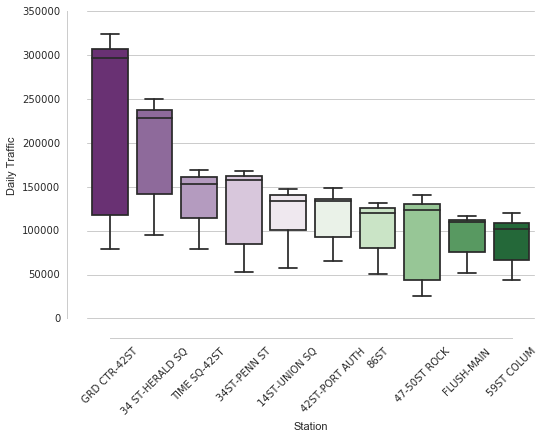

In [304]:
sns.set(style="ticks")
sns.set_style("whitegrid")

# Load the example tips dataset
#tips = sns.load_dataset("tips")

# Draw a nested boxplot to show bills by day and sex
labels = ['GRD CTR-42ST', '34 ST-HERALD SQ', 'TIME SQ-42ST', '34ST-PENN ST', '14ST-UNION SQ', '42ST-PORT AUTH', '86ST', '47-50ST ROCK', 'FLUSH-MAIN', '59ST COLUM']
bp = sns.boxplot(data=pt_day_final, palette="PRGn")
sns.despine(offset=20, trim=True)
bp.set_xticklabels(labels, rotation=45)
bp.set(xlabel='Station', ylabel='Daily Traffic')

In [305]:
pt_tb = pd.pivot_table(df, index = ['Station', 'LineName'], columns = ['TimeBlock'], values = ['Traffic'], aggfunc=np.sum, margins=True, fill_value=0)
pt_tb.sort_values(by=('Traffic', 'All'), ascending=False, inplace=True)
pt_tb_10 = pt_tb[0:11]
pt_tb_rm_row = pt_tb_10['Traffic'].iloc[1:]
pt_tb_final = pt_tb_rm_row.T.iloc[:-1]

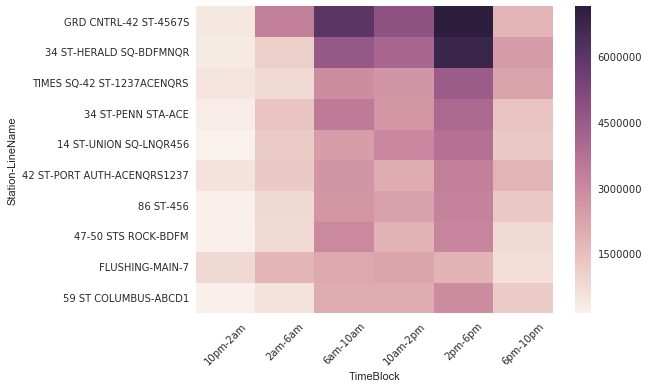

In [320]:
#pt_interval_final[(pt_interval_final.T != 0).any()].T
#pt_tb_final.T
labels = ['10pm-2am', '2am-6am', '6am-10am', '10am-2pm', '2pm-6pm', '6pm-10pm']
hm = sns.heatmap(pt_tb_final.T)
hm.set_xticklabels(labels, rotation=45)

In [307]:
#pt_tb_final.T.plot()

In [310]:
pt_wday = pd.pivot_table(df, index = ['Station', 'LineName'], columns = ['Weekday'], values = ['Traffic'], aggfunc=np.sum, margins=True, fill_value=0)
pt_wday.sort_values(by=('Traffic', 'All'), ascending=False, inplace=True)
pt_wday_10 = pt_wday[0:11]
pt_wday_rm_row = pt_wday_10['Traffic'].iloc[1:]
pt_wday_final = pt_wday_rm_row.T.iloc[:-1]
pt_wday_final

Station,GRD CNTRL-42 ST,34 ST-HERALD SQ,TIMES SQ-42 ST,34 ST-PENN STA,14 ST-UNION SQ,42 ST-PORT AUTH,86 ST,47-50 STS ROCK,FLUSHING-MAIN,59 ST COLUMBUS
LineName,4567S,BDFMNQR,1237ACENQRS,ACE,LNQR456,ACENQRS1237,456,BDFM,7,ABCD1
Weekday,,,,,,,,,,
1,3921619.0,3001074.0,1945806.0,2099276.0,1741765.0,1780669.0,1587773.0,1625232.0,1475821.0,1382984.0
2,4302755.0,3246832.0,2162051.0,2235281.0,1898180.0,1868411.0,1735299.0,1795608.0,1548116.0,1503923.0
3,4294903.0,3332899.0,2260905.0,2259063.0,1982555.0,1904289.0,1744574.0,1826474.0,1570550.0,1544733.0
4,4324688.0,3334583.0,2262558.0,2283937.0,1961627.0,1914953.0,1746150.0,1826573.0,1552470.0,1544229.0
5,3982170.0,3301184.0,2223453.0,2230854.0,1940730.0,1935667.0,1724260.0,1719155.0,1515897.0,1368217.0
6,1598164.0,1919011.0,1618147.0,1155312.0,1378089.0,1271497.0,1137711.0,572419.0,1048533.0,892265.0
7,1205116.0,1435324.0,1253532.0,936132.0,1003830.0,1020296.0,859680.0,438695.0,819443.0,714902.0


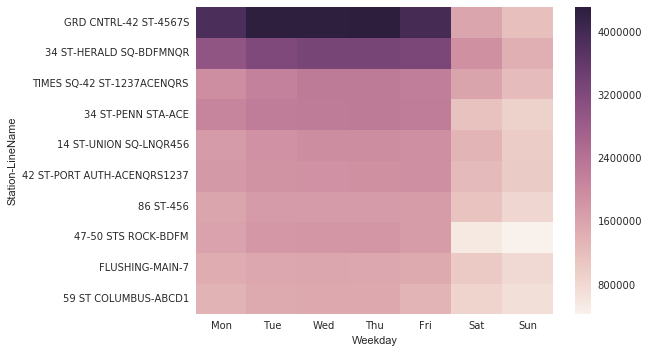

In [319]:
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
wd = sns.heatmap(pt_wday_final.T)
wd.set_xticklabels(labels)